In [781]:
using Plots
using StatsBase
using DataFrames

using LinearAlgebra 
using SparseArrays 
using StructArrays
using StaticArrays
using StaticRanges

using IterativeSolvers
using Preconditioners

using BenchmarkTools
using Profile

# Main

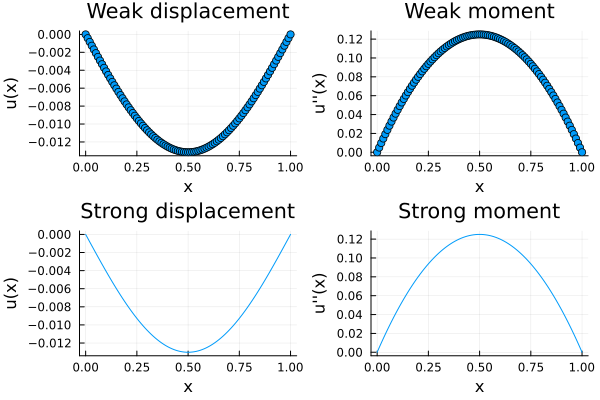

In [804]:
option = 3;
nelements = 100; 
nnodes = nelements+1; 
h = 1/nelements;
x = Vector(0:h:1);
p = weak_form(x, nelements, nnodes, option)
q = plot_strong(option)
plot(p,q, layout=(2,1))

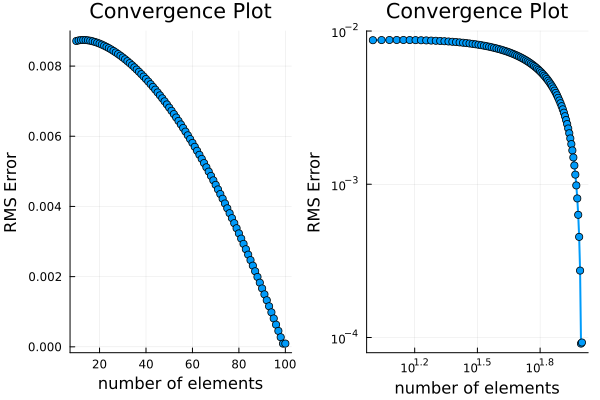

In [805]:
c = convergence(option)
cl = convergence_log(option)
plot(c,cl, layout=2)

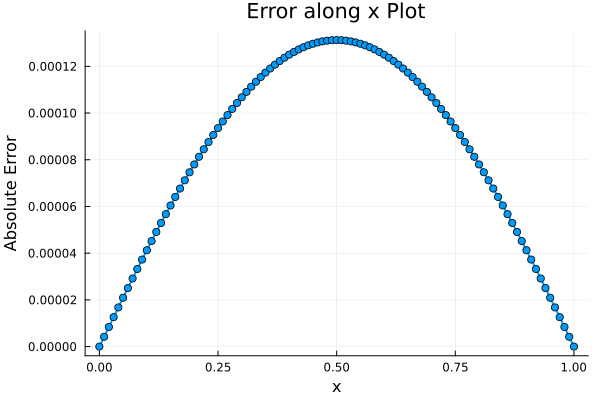

In [784]:
error_x(option)

# Strong Form

In [785]:
# define the so-called source function 
function strong_form(x, option)
    if option == 1
    # Case 1
        return x^4/12-x/12+1/2
    elseif option == 2
    # Case 2
        return x^4-2*x^3+(3/2)*x^2-x/2+1/16
    elseif option == 3
    # Case 3
        f = -(x^4)/24+(x^3)/12-x/24
        M = -(x^2)/2+x/2
        return f, M
    else
        println("Invalid choice !!")
    end
end 


strong_form (generic function with 2 methods)

In [786]:
#plot(x,f)
#title!("Strong Form")
#xlabel!("x")
#ylabel!("U(x)")

function plot_strong(option)
    if option == 1 || option == 2
        f = strong_form.(x, option)
        #..plot the solution  
        p=plot(x,f,legend=false)
        xlabel!("x") 
        ylabel!("u(x)")
        title!("Strong displacement")
    elseif option == 3
        ans = strong_form.(x, option)
        f = first.(ans)
        M = last.(ans)
        p1=plot(x,f,legend=false)
        xlabel!("x") 
        ylabel!("u(x)")
        title!("Strong displacement")
        #..plot the solution  
        p2=plot(x,M,legend=false)
        xlabel!("x") 
        ylabel!("u''(x)")
        title!("Strong moment")
        plot(p1,p2,layout=(1,2))
    end
end




plot_strong (generic function with 1 method)

# Weak form

In [787]:
function weak_form(x, nelements, nnodes, option)

    #..Initialize local and global matrix and right-hand side value 
    floc = zeros(Float64,2, 1)
    Aloc = zeros(Float64,2,2)
    A = zeros(Float64,nnodes, nnodes)
    f = zeros(Float64,nnodes) 
    
    #..Mesh with points and edges 
    #..point holds the coordinates of the left and right node of the element
    #..edges holds the global indices of the left and right node of the element
    points = collect( [x[i], x[i+1]] for i in 1:nelements) 
    edges = collect( [i, i+1] for i in 1:nelements) 
    
    #..Set the source 
    if option == 1
        u = weak_form_1(x, nelements, nnodes)    
        #..plot the solution  
        p1=plot(x,u,shape=:circle,lw=2,legend=false)
        xlabel!("x") 
        ylabel!("u(x)")
        title!("Weak displacement")
    elseif option == 2
        u = weak_form_2(x, nelements, nnodes)    
        #..plot the solution  
        p1=plot(x,u,shape=:circle,lw=2,legend=false)
        xlabel!("x") 
        ylabel!("u(x)")
        title!("Weak displacement")
    elseif option == 3
        uv = weak_form_3(x, nelements, nnodes)
        u = uv[1:nnodes]
        v = uv[nnodes+1:end]
        
        #..plot the solution  
        p1=plot(x,u,shape=:circle,lw=2,legend=false)
        xlabel!("x") 
        ylabel!("u(x)")
        title!("Weak displacement")
        
        p2=plot(x,v,shape=:circle,lw=2,legend=false)
        xlabel!("x") 
        ylabel!("u''(x)")
        title!("Weak moment")
        
        plot(p1,p2,layout=(1,2))
    end
end


weak_form (generic function with 2 methods)

In [788]:
function weak_form_1(x, nelements, nnodes)
#..Mesh with points and edges 
    #..point holds the coordinates of the left and right node of the element
    #..edges holds the global indices of the left and right node of the element
    points = collect( [x[i], x[i+1]] for i in 1:nelements) 
    edges = collect( [i, i+1] for i in 1:nelements) 
    
    #..Set the source 
    
    # Case 1
    fsource(x) = x*x
    
    #..Initialize local and global matrix and right-hand side value 
    floc = zeros(Float64,2, 1)
    Aloc = zeros(Float64,2,2)
    A = zeros(Float64,nnodes, nnodes)
    f = zeros(Float64,nnodes)  
    
    #..Perform loop over elements and assemble global matrix and vector 
    for i=1:nelements 
    
      xl, xr = points[i,:][1]
      floc = -(xr-xl)/2 * [fsource(xl), fsource(xr)]
      Aloc = (1/(xr-xl))*[1 -1; -1 1]
    
      for j=1:2 
        f[edges[i][j]] += floc[j]
        for k =1:2 
          A[edges[i][j], edges[i][k]] += Aloc[j,k]
        end 
      end 
    
    end
    
    #..handle the boundary conditions in the matrix and right-hand side vector 
    
    # Case 1
    A[1,1] = 1;     A[1,2] = 0;        f[1]   = 1/2
    A[end,end-1]=0; A[end,end] = 1;    f[end] = 1/2

    #..solve the linear system
    u = A \ f
    return u
end

weak_form_1 (generic function with 1 method)

In [789]:
function weak_form_2(x, nelements, nnodes)
#..Mesh with points and edges 
    #..point holds the coordinates of the left and right node of the element
    #..edges holds the global indices of the left and right node of the element
    points = collect( [x[i], x[i+1]] for i in 1:nelements) 
    edges = collect( [i, i+1] for i in 1:nelements) 
    
    #..Set the source 
    
    # Case 2
    fsource(x) = 12*(x-0.5)^2

    #..Initialize local and global matrix and right-hand side value 
    floc = zeros(Float64,2, 1)
    Aloc = zeros(Float64,2,2)
    A = zeros(Float64,nnodes, nnodes)
    f = zeros(Float64,nnodes)  
    
    #..Perform loop over elements and assemble global matrix and vector 
    for i=1:nelements 
    
      xl, xr = points[i,:][1]
      floc = -(xr-xl)/2 * [fsource(xl), fsource(xr)]
      Aloc = (1/(xr-xl))*[1 -1; -1 1]
    
      for j=1:2 
        f[edges[i][j]] += floc[j]
        for k =1:2 
          A[edges[i][j], edges[i][k]] += Aloc[j,k]
        end 
      end 
    
    end
    
    #..handle the boundary conditions in the matrix and right-hand side vector 

    # Case 2
    A[1,1] = 1;     A[1,2] = 0;        f[1]   = 1/16
    A[end,end-1]=0; A[end,end] = 1;    f[end] = 1/16
    
    #..solve the linear system
    u = A \ f
    return u
end

weak_form_2 (generic function with 1 method)

In [803]:
function weak_form_3(x, nelements, nnodes)
    #..Mesh with points and edges 
    #..point holds the coordinates of the left and right node of the element
    #..edges holds the global indices of the left and right node of the element
    points = collect( [x[i], x[i+1]] for i in 1:nelements) 
    edges = collect( [i, i+1] for i in 1:nelements) 
    
    #..Set the source 
    
    # Case 3
    fsource(x) = 1
    
    #..Initialize local and global matrix and right-hand side value 
    floc = zeros(Float64,2, 1)
    Aloc = zeros(Float64,2,2)
    A = zeros(Float64,nnodes, nnodes)
    f = zeros(Float64,nnodes)  
    
    #..Perform loop over elements and assemble global matrix and vector 
    for i=1:nelements 
    
      xl, xr = points[i,:][1]
      floc = (xr-xl)/2 * [fsource(xl), fsource(xr)]
      Aloc = (1/(xr-xl))*[1 -1; -1 1]
    
      for j=1:2 
        f[edges[i][j]] += floc[j]
        for k =1:2 
          A[edges[i][j], edges[i][k]] += Aloc[j,k]
        end 
      end 
    
    end
    
    #..handle the boundary conditions in the matrix and right-hand side vector 
    # Case 3
    A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0
    A[end,end-1]=0; A[end,end] = 1;    f[end] = 0

    I = UniformScaling(nnodes);
    nul = 0*I;
    B = [-A/h -I*h; nul A];
    ff = [0*f; f];
    
    #..solve the linear system
    uv = B \ ff
    return uv
end

weak_form_3 (generic function with 1 method)

# Convergence

In [791]:
function convergence(option)
    rmse_array = Vector{Float64}()
    for nelements = 10:100
        h = 1/nelements;
        nnodes = nelements+1
        x = Vector(0:h:1);
        if option == 1
            f = strong_form.(x, option);
            u = weak_form_1(x, nelements, nnodes)
            rmse = rmsd(u, f; normalize=false);
            append!(rmse_array, rmse);
        elseif option == 2
            f = strong_form.(x, option);
            u = weak_form_2(x, nelements, nnodes) 
            rmse = rmsd(u, f; normalize=false);
            append!(rmse_array, rmse);
        elseif option == 3
            ans = strong_form.(x, option)
            f = first.(ans)
            #M = last.(ans)
            uv = weak_form_3(x, nelements, nnodes)
            u = uv[1:nnodes]
            #v = uv[nnodes+1:end]
            rmse = rmsd(u, f; normalize=false);
            append!(rmse_array, rmse);
        end
        
    end
    x = Vector(10:100);
    p3=plot(x,rmse_array,shape=:circle,lw=2,legend=false)
    title!("Convergence Plot")
    xlabel!("number of elements")
    ylabel!("RMS Error")
end

convergence (generic function with 1 method)

In [792]:
function convergence_log(option)
    rmse_array = Vector{Float64}()
    for nelements = 10:100
        h = 1/nelements;
        nnodes = nelements+1
        x = Vector(0:h:1);
        f = strong_form.(x, option);
        if option == 1
            u = weak_form_1(x, nelements, nnodes)
            rmse = rmsd(u, f; normalize=false);
            append!(rmse_array, rmse);
        elseif option == 2
            u = weak_form_2(x, nelements, nnodes) 
            rmse = rmsd(u, f; normalize=false);
            append!(rmse_array, rmse);
        elseif option == 3
            uv = weak_form_3(x, nelements, nnodes)
            u = uv[1:nnodes]
            v = uv[nnodes+1:end]
            rmse = rmsd(u, first.(f); normalize=false);
            append!(rmse_array, rmse);
        end
        
    end
    x = Vector(10:100);
    p3=plot(x,rmse_array,shape=:circle,lw=2,legend=false, xaxis=:log, yaxis=:log)
    title!("Convergence Plot")
    xlabel!("number of elements")
    ylabel!("RMS Error")
end

convergence_log (generic function with 1 method)

In [793]:
function error_x(option)
    error_array = Vector{Float64}()
    for i = 1:nelements+1
        f = strong_form.(x, option);
        if option == 1
            u = weak_form_1(x, nelements, nnodes)   
            error = abs(u[i]-f[i])
            append!(error_array, error);
        elseif option == 2
            u = weak_form_2(x, nelements, nnodes)  
            error = abs(u[i]-f[i])
            append!(error_array, error);
        elseif option == 3
            uv = weak_form_3(x, nelements, nnodes)
            u = uv[1:nnodes]
            v = uv[nnodes+1:end]
            error = abs(u[i]-first.(f)[i])
            append!(error_array, error);
        end
        
    end
    
    p3=plot(x,error_array,shape=:circle,lw=2,legend=false)
    title!("Error along x Plot")
    xlabel!("x")
    ylabel!("Absolute Error")
end

error_x (generic function with 1 method)

In [794]:
# Extract the slope from the coefficients
y2 = log.(rmse_array)[end]
y1 = log.(rmse_array)[1]
x2 = log.(x)[end]
x1 = log.(x)[1]
slope = (y2-y1)/(x2-x1)

# Display the slope
println("Slope: $slope")

Slope: -0.0
